# NLP sentiment analysis classification for stock market comments

#### Import Statements

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from plotly import graph_objs as go
import re
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import random

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [14]:
df = pd.read_csv('stock_data.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [16]:
df['Length'] = df['Text'].apply(lambda x: len(x.split(' ')))
df.head()

,Text,Sentiment,Length
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,21
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,19
2,user I'd be afraid to short AMZN - they are lo...,1,18
3,MNTA Over 12.00,1,5
4,OI Over 21.37,1,6


In [17]:
max(df['Length'])

32

Check for data distribution

In [18]:

df['Sentiment'].value_counts()

 1    3685
-1    2106
Name: Sentiment, dtype: int64

c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Sentiment', ylabel='count'>

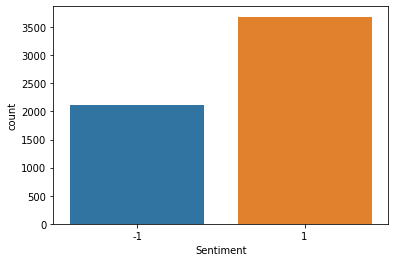

In [19]:
sns.countplot(df['Sentiment'])

In [20]:
positive_df = df[df['Sentiment'] == 1]['Length'].value_counts().sort_index()
negative_df = df[df['Sentiment'] == -1]['Length'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=positive_df.index,
    y=positive_df.values,
    name='Positive',
    fill='tozeroy',
    
))
fig.add_trace(go.Scatter(
    x=negative_df.index,
    y=negative_df.values,
    name='Negative',
    fill='tozeroy',

))
fig.update_layout(
    title='Distribution of Message Length'
)
fig.update_xaxes(range=[0, 70])
fig.show()

#### Data Pre-processing

Changing to lower case, removing links, punctuation

In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
df['Text_Cleaned'] = df['Text'].apply(clean_text)
df.head()

,Text,Sentiment,Length,Text_Cleaned
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,21,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,19,user aap movie return for the feageed indicat...
2,user I'd be afraid to short AMZN - they are lo...,1,18,user id be afraid to short amzn they are look...
3,MNTA Over 12.00,1,5,mnta over
4,OI Over 21.37,1,6,oi over


Removing Stopwords

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raych\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [25]:
df['Text_Cleaned'] = df['Text_Cleaned'].apply(remove_stopwords)
df.head()

,Text,Sentiment,Length,Text_Cleaned
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,21,kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,19,user aap movie return feageed indicator trad...
2,user I'd be afraid to short AMZN - they are lo...,1,18,user id afraid short amzn looking like nearmo...
3,MNTA Over 12.00,1,5,mnta
4,OI Over 21.37,1,6,oi


Change -1 to 0 for Sentiment

In [26]:
df = df.replace([-1],0)

In [27]:
df['Sentiment'].unique()

array([1, 0], dtype=int64)

In [28]:
df.head()

,Text,Sentiment,Length,Text_Cleaned
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,21,kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,19,user aap movie return feageed indicator trad...
2,user I'd be afraid to short AMZN - they are lo...,1,18,user id afraid short amzn looking like nearmo...
3,MNTA Over 12.00,1,5,mnta
4,OI Over 21.37,1,6,oi


#### WordCloud Visualisation

Positive Sentiment

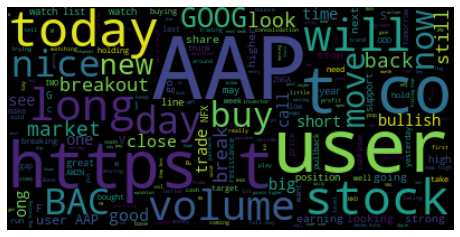

In [29]:
text = " ".join([x for x in df.Text[df.Sentiment==1]])

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Negative Sentiment

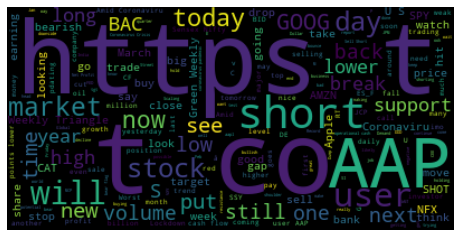

In [30]:
text = " ".join([x for x in df.Text[df.Sentiment==0]])

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Vectorization    

In [31]:
x = df['Text_Cleaned']
y = df['Sentiment']

In [32]:

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=24, test_size = 0.25)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4343 4343
1448 1448


In [33]:
from sklearn.feature_extraction.text import CountVectorizer


vector = CountVectorizer()
vector.fit(x_train)

CountVectorizer()

In [34]:
x_train_dtm = vector.transform(x_train)
x_test_dtm = vector.transform(x_test)

TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4343x7530 sparse matrix of type '<class 'numpy.float64'>'
	with 35626 stored elements in Compressed Sparse Row format>

In [36]:
import plotly.figure_factory as ff

x_axes = ['Positive', 'Negative']
y_axes =  ['Negative', 'Positive']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='Confusion matrix',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

Create Multinomial Naive Bayes model

In [37]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_tfidf, y_train)

MultinomialNB()

In [38]:
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [39]:
# calculate accuracy of class predictions
from sklearn import metrics
print(accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.7734806629834254
              precision    recall  f1-score   support

           0       0.72      0.53      0.61       485
           1       0.79      0.90      0.84       963

    accuracy                           0.77      1448
   macro avg       0.76      0.71      0.73      1448
weighted avg       0.77      0.77      0.76      1448



Future Work: Results would probably be improved if using BERT

#### References

https://www.kaggle.com/code/rohit0906/stock-sentiment-analysis-using-news-headlines/notebook

https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

https://www.kaggle.com/code/sandeepthimmappa/natural-language-processing-sentiment-analysis